### What does adding noise to dac codes do?

In [1]:
DEVICE='cpu' # either 'cuda' or 'cpu'
%pwd
%cd /app

/app


In [2]:
import dac
from audiotools import AudioSignal

import torch

import numpy as np
import random
import time

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

In [4]:
if DEVICE == 'cuda' :
    torch.cuda.device_count()
    torch.cuda.get_device_properties(0).total_memory/1e9
    #torch.cuda.get_device_properties(1).total_memory/1e9
    #device = torch.device("cuda:0") # if the docker was started with --gpus all, then can choose here.
device = torch.device(DEVICE) # if the docker was started with --gpus all, then can choose here.
device

device(type='cpu')

In [5]:
model_path = dac.utils.download(model_type="16khz") 
wavefilepath="dacdevdata/16kHz/N12/PisWinAppBee_sparse_recon/"
sample_length=16000  # will shorten input files to save memory

### This model doesn't sound as good - because it was trained on different data???
#model_path = "/scratch/codecs/codec.pth" # /the default model from vampnet!
model = dac.DAC.load(model_path)
model.to(device); #wanna see the model? remove the semicolon

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


<div style="height: 10px; background-color: blue;"></div>
<span style="font-size: 24px; color:blue">Utils </span>

In [6]:
import torch
"""
    Interpolates and interleaves vectors within the input tensor.
    Basically "upsampling" by inserting interpolated vectors between neighbors in the input.

    Args:
        input_tensor (torch.Tensor): A PyTorch tensor with shape [1, a, b].

    Returns:
        torch.Tensor: A tensor with shape [1, a, 2*b - 1], where vectors are interpolated
        and interleaved with the original vectors along the last dimension.

    Example:
        >>> input_tensor = torch.randn(1, 3, 4)
        >>> output_tensor = interpolate_and_interleave(input_tensor)
"""
def interpolate_and_interleave(input_tensor):
    # Get the shape of the input tensor
    input_shape = input_tensor.shape

    # Compute vectors halfway between neighbors
    output_vectors = 0.5 * (input_tensor[:, :, :-1] + input_tensor[:, :, 1:])

    # Create a new tensor with the correct shape [1, a, 2*b - 1]
    interleaved_tensor = torch.empty((input_shape[0], input_shape[1], 2 * input_shape[2] - 1),
                                     dtype=input_tensor.dtype, device=input_tensor.device)

    # Copy input vectors and interpolated vectors to the new tensor
    interleaved_tensor[:, :, ::2] = input_tensor
    interleaved_tensor[:, :, 1::2] = output_vectors

    return interleaved_tensor


In [7]:
#Example
input_tensor = torch.randn(1, 1, 4)
print(input_tensor)
output_tensor = interpolate_and_interleave(input_tensor)
print(output_tensor)

tensor([[[ 1.3102, -0.4731, -0.2394, -0.5106]]])
tensor([[[ 1.3102,  0.4186, -0.4731, -0.3562, -0.2394, -0.3750, -0.5106]]])


In [8]:
#####    CHOOSE A SOUND

#snd2='/DSApplause--numClappers_exp-00.50--c-01--x-01.wav' 
#snd2='/DSPistons--rate_exp-00.50--c-01--x-01.wav'
snd2='DSBugs--busybodyFreqFactor-00.50--c-01--x-01.wav' #'/DSBugs--busybodyFreqFactor-00.50.wav'
#snd2='/DSWind--strength-00.50--c-01--x-01.wav'


<div style="height: 10px; background-color: blue;"></div>
<span style="font-size: 24px; color:blue">Load a file and code it</span>

In [9]:
#first load a wave file, 
bee = AudioSignal(wavefilepath + snd2) # 2-second sound at 16kHz
bee = bee[0,0,: sample_length] # cortado, otherwise the computation will bust memory


# #bee_compressed = model.compress(bee)
# #print(f'bee_compressed.codes.shape = {bee_compressed.codes.shape}')
# #print(bee_compressed)

#get the z vectors that we can use to get a "reconstructed" version (because we will be also reconstructing from artifical z's later, and want to have the padding, etc all be the same between the original and the artifical sound)
bee.to(model.device)
bee_x = model.preprocess(bee.audio_data, bee.sample_rate)

print(f'bee_x is {bee_x} with shape {bee_x.shape}')

########  ENCODE
with torch.no_grad():
    bee_z, bee_codes, bee_latents, _, _ = model.encode(bee_x) # , n_quantizers=1) # model.encode(bee_x, 4)
print(f'### ENCODE ---  bee_z is {bee_z} with shape {bee_z.shape}')
print(f'### ENCODE ---  bee_codes is {bee_codes} with shape {bee_codes.shape}')
print(f'### ENCODE ---  bee_latents is {bee_latents} with shape {bee_latents.shape}')
########  DECODE
with torch.no_grad():
    beerecon = model.decode(bee_z) # now we have something that we can use to compare with artificial z vectors
print(f'### DECODE ---  beerecon is {beerecon} with shape {beerecon.shape}')


# bee.to(model.device)
# bee_x = model.preprocess(bee.audio_data, bee.sample_rate)

########  ENCODE
with torch.no_grad():
    recon_z, recon_codes, recon_latents, _, _ = model.encode(torch.cat((beerecon, torch.zeros(1, 1, 4, device=device)), dim=2)) # , n_quantizers=1) # model.encode(bee_x, 4)
print(f'### ENCODE --- recon_z.shape = {recon_z.shape},  recon_codes.shape = {recon_codes.shape}, recon_latents.shape = {recon_latents.shape}')

########  DECODE
with torch.no_grad():
    beerecon2 = model.decode(recon_z) # now we have something that we can use to compare with artificial z vectors
print(f'### DECODE ---  beerecon2 is {beerecon2} with shape {beerecon2.shape}')



# bee_compressed = model.compress(beerecon)
# print(bee_compressed)
# bee_compressed.shape

bee_x is tensor([[[0.0403, 0.0438, 0.0412,  ..., 0.1259, 0.1339, 0.1411]]]) with shape torch.Size([1, 1, 16000])
### ENCODE ---  bee_z is tensor([[[-4.0137, -7.5234,  1.3160,  ...,  1.5690, -2.2619, -2.5634],
         [ 2.4781,  2.2357, -5.8321,  ...,  5.9433,  0.6475,  1.5625],
         [-4.7342, -4.2328,  1.4892,  ..., -5.5452, -0.7169, -7.3004],
         ...,
         [-0.5590,  4.1461,  0.1514,  ..., -2.3488,  3.0828,  2.4457],
         [-5.2625, -2.7701, -4.7593,  ..., -1.5464, -3.0690, -0.0872],
         [ 6.3632, -1.2465,  2.7457,  ..., -3.0642, -7.4089, -7.1540]]]) with shape torch.Size([1, 1024, 50])
### ENCODE ---  bee_codes is tensor([[[ 301,  118,  118,  575,  190,  243,  742,  878,  990,  990,  990,
           990,  420,  250,  479,  708,  746,  742,  662,  742,   95,  271,
           338,  551,  338,  551,  169,  293,  720,  491,  382,  595,  254,
           626,  111,  293,  746,  575,  382,  812,  165,  662,  662,  342,
           190, 1013,  685,  533,  751,   52],
   

In [10]:
bee.to(model.device)
bee_x = model.preprocess(bee.audio_data, bee.sample_rate)
with torch.no_grad():
    bee_z, bee_codes, bee_latents, _, _ = model.encode(bee_x, n_quantizers=1) # model.encode(bee_x, 4)

print(f'bee_z.shape = {bee_z.shape}')
print(f'bee_z 1 time slize slice = {bee_z[0,:,40]}')
print(f'bee_codes.shape = {bee_codes.shape}')

bee_z.shape = torch.Size([1, 1024, 50])
bee_z 1 time slize slice = tensor([ 1.1735, -0.4478, -3.7594,  ..., -2.7554, -1.4403, -7.4421])
bee_codes.shape = torch.Size([1, 12, 50])


In [11]:
beerecon = model.decode(bee_z)
print(f'Shape of reconstructed signal is {beerecon.shape}')

# beereconsignal = beerecon[0,0,:].cpu().detach().numpy()
# plt.plot(beereconsignal)
# ipd.Audio(beereconsignal, rate=44100)

Shape of reconstructed signal is torch.Size([1, 1, 15992])


<div style="height: 10px; background-color: blue;"></div>
<span style="font-size: 24px; color:blue">Now mess with it and adjust the meta data to reflect the messing</span>

In [12]:
#First get tensors and signals we will need:

#messmethod="INTERPOLATE"
#messmethod="CONTRACT"
#messmethod="EXPAND"
#messmethod="SHIFT"
messmethod="RANDPERTURB"
#messmethod="REVERSE"

if messmethod =="INTERPOLATE" :
    sloebee_z = interpolate_and_interleave(bee_z)
    sloebee_z = sloebee_z[:,:, : int(bee_z.shape[2])] #run out of memory if too long, so shorten to original sound length
elif messmethod=="CONTRACT" :
     sloebee_z = .15*bee_z
elif messmethod=="EXPAND" :
     sloebee_z = 1.8*bee_z
elif messmethod=="SHIFT" :
     sloebee_z = bee_z+10
elif messmethod=="RANDPERTURB" :
     sloebee_z = bee_z+30*torch.rand_like(bee_z)
elif messmethod=="REVERSE" :
     sloebee_z = torch.flip(bee_z, dims=(2,))
     #sloebee_z = bee_z
    
with torch.no_grad():
    sloebeerecon = model.decode(sloebee_z)
print(f'sloebeerecon.shape is {sloebeerecon.shape}..........bee.shape is {bee.shape}')
sloebee=AudioSignal(sloebeerecon, sample_rate=16000)
sloebee_compressed = model.compress(sloebee)
sloebee_compressed

sloebeerecon.shape is torch.Size([1, 1, 15992])..........bee.shape is torch.Size([1, 1, 16000])


DACFile(codes=tensor([[[ 962,  335,  118,   91,  575,  230,  169, 1019,   91,  662,  662,
            91,  174,  914,  636,  169,   47,  169,  812,  519,   74,    2,
           800,  271,  923,  551,  584,    2,  931,  577,  255,  718,  576,
           837,  527,   30,  338,  181,   74,  708,  250,  169,  812,  812,
           190,   59,  708,  387,   58,  707],
         [ 987,  609,  773,  493,  631,  190,   53,   32,  345,   88,  711,
           696,   47,  512,  857,  925,  429,  287,  139,  147,  857,  143,
           345,  965,  327,  787,  180,  570,  969,  739,  682,  466,  931,
           771,   63,  914,  818,  228,  100,  722,  717,  590,  783,  714,
           338,   20,  782,  437,  570,  898],
         [ 553,  915,  526,  835,  863,  484,  120,    5,  616,  441,  338,
           830,  411,  132,  203,  185,  120,  601,  650,  863,  908,  824,
            95,  961,  564,   47,  929,  222,  893,  855,  964,  427,  579,
           804,  804,  586,  494,  650,   74,  831,  717

In [13]:

#-----------------------------------------------------------
#A little analysis:
print(f'sloebee_z.shape = {sloebee_z.shape}')
print(f'bee_z 1 time slize slice = {bee_z[0,:,40]}')
print(f'sloebee_z 1 time slize slice = {sloebee_z[0,:,40]}')

l2_norm = torch.norm(bee_z - sloebee_z, 2)
print("L2 Norm:", l2_norm.item())


# print(f'bee_compressed.codes.shape = {bee_compressed.codes.shape}')
# print(f'sloebee_compressed.codes.shape = {sloebee_compressed.codes.shape}')

# numcodebooks=1
# t1=bee_compressed.codes[0,numcodebooks-1,:]
# t2=sloebee_compressed.codes[0,numcodebooks-1,:]
# same_elements = (t1 == t2).sum().item()
# print("Ratio of codes that are the same in the {t1.numel()} elements that make up the first {numcodebooks} codeboods is ", same_elements/t1.numel())








sloebee_z.shape = torch.Size([1, 1024, 50])
bee_z 1 time slize slice = tensor([ 1.1735, -0.4478, -3.7594,  ..., -2.7554, -1.4403, -7.4421])
sloebee_z 1 time slize slice = tensor([21.6524,  0.0870, -1.7218,  ...,  3.2293, 13.9991,  6.0322])
L2 Norm: 3920.217041015625


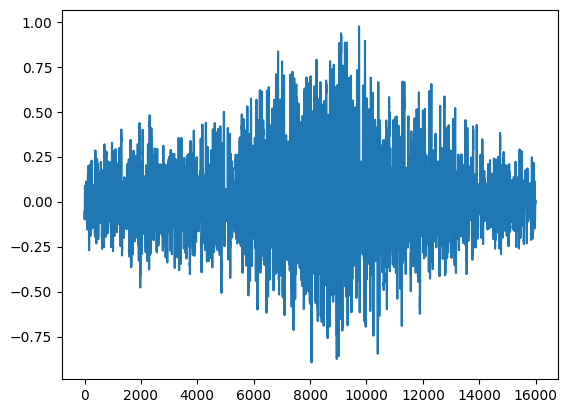

In [14]:
sloebeereconsignal = sloebeerecon[0,0,:].cpu().detach().numpy()

plt.plot(sloebeereconsignal)
ipd.Audio(sloebeereconsignal, rate=16000)

In [15]:
# my_dac_file = dac.DACFile(
#         codes=sloebee_z,
#         chunk_length=bee_compressed.chunk_length,
#         original_length=2*bee_compressed.original_length,
#         input_db=bee_compressed.input_db,
#         channels=bee_compressed.channels,
#         sample_rate=bee_compressed.sample_rate,
#         padding=bee_compressed.padding,
#         dac_version=bee_compressed.dac_version,
#     )